In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessio

/kaggle/input/nppe-2-automatic-disfluency-restoration/unique_disfluencies.csv
/kaggle/input/nppe-2-automatic-disfluency-restoration/train.csv
/kaggle/input/nppe-2-automatic-disfluency-restoration/test.csv
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/3669347362.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/9210085611.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/0986418753.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/1259464204.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/2481287452.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/6201206544.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/7745308610.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/0743909061.wav
/kaggle/input/nppe-2-automatic-disfluency-restoration/downloaded_audios/7150321081.wav
/kaggle/inpu

In [2]:
!pip install -q datasets==3.6.0 soundfile jiwer accelerate huggingface_hub evaluate librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB

In [3]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 90.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import json
import torch
import torch.nn as nn
from pathlib import Path
from tqdm.auto import tqdm
import soundfile as sf
import librosa
import re

from datasets import load_dataset, Dataset, Audio
from transformers import (
    AutoFeatureExtractor,
    AutoModel,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    Trainer,
    Seq2SeqTrainer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
)

from torch.nn.utils.rnn import pad_sequence
import evaluate

from dataclasses import dataclass
from typing import List, Dict, Any

2025-11-17 09:20:31.627468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763371231.928375      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763371231.974929      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
import matplotlib.pyplot as plt

In [6]:
DATA_DIR  = Path("/kaggle/input/nppe-2-automatic-disfluency-restoration")
TRAIN_CSV = DATA_DIR / "train.csv"
TEST_CSV  = DATA_DIR / "test.csv"
DISF_CSV  = DATA_DIR / "unique_disfluencies.csv"
AUDIO_DIR = DATA_DIR / "downloaded_audios"

ASR_CACHE = Path('/kaggle/working/asr_cache.json')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
train_df = pd.read_csv(TRAIN_CSV)
train_df["id"] = train_df["id"].astype(str).str.zfill(10)
test_df  = pd.read_csv(TEST_CSV)
disf_df  = pd.read_csv(DISF_CSV)

phrases = [tuple(str(x).strip().split()) for x in disf_df['disfluency'].dropna().astype(str)]
phrases = sorted(set([p for p in phrases if len(p) > 0]), key=len, reverse=True)

def remove_disfluencies_phrase(text):
    if pd.isna(text):
        return ""
    toks = str(text).strip().split()
    n = len(toks)
    remove = [False] * n
    i = 0
    while i < n:
        matched = False
        for ph in phrases:
            L = len(ph)
            if i + L <= n and tuple(toks[i:i+L]) == ph:
                for k in range(i, i+L):
                    remove[k] = True
                i += L
                matched = True
                break
        if not matched:
            i += 1
    return " ".join([t for t, m in zip(toks, remove) if not m])

train_df['clean_transcript'] = train_df['transcript'].apply(remove_disfluencies_phrase)

print(train_df['transcript'].iloc[0])
print("--")
print(train_df['clean_transcript'].iloc[0])

अनमैरिड है तो कहीं न कहीं जॉब करते जो भी है लेकिन कहीं न कहीं सपोर्ट होना जरूरी है किसी न किसी का जैसे कि आ अभी आप इतने व्यस्त होने के कारण उम्म फिर भी तनाव रहता ही है इंसान को तो क्योंकि आज के लाइफ में समय समय नहीं है किसी के पास में
--
अनमैरिड है तो कहीं न कहीं जॉब करते जो भी है लेकिन कहीं न कहीं सपोर्ट होना जरूरी है किसी न किसी का जैसे कि आ अभी आप इतने व्यस्त होने के कारण फिर भी तनाव रहता ही है इंसान को तो क्योंकि आज के लाइफ में समय समय नहीं है किसी के पास में


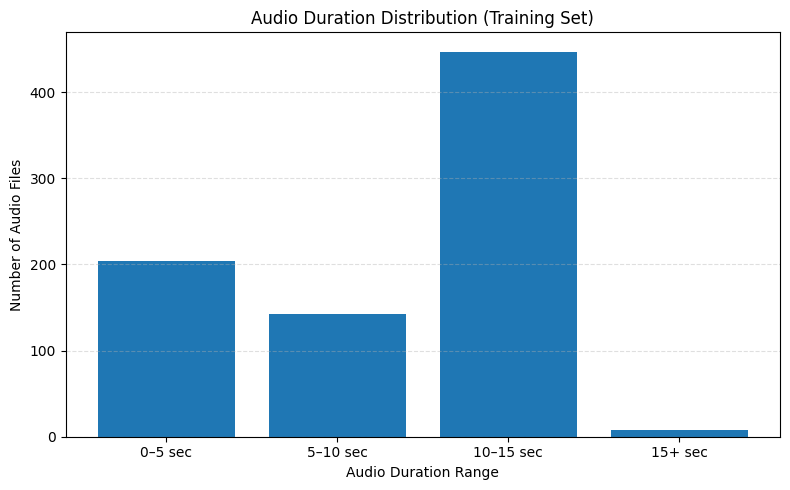

In [8]:
train_ids = pd.read_csv(TRAIN_CSV)["id"].astype(str).tolist()
durations = []

for sid in train_ids:
    wav_path = AUDIO_DIR / f"{sid}.wav"
    if not wav_path.exists():
        continue

    try:
        audio, sr = sf.read(wav_path)

        duration = len(audio) / sr
        durations.append(duration)
    except Exception as e:
        print(f"Error reading {wav_path}: {e}")

durations = np.array(durations)

bucket_0_5   = ((durations >= 0)  & (durations < 5)).sum()
bucket_5_10  = ((durations >= 5)  & (durations < 10)).sum()
bucket_10_15 = ((durations >= 10) & (durations < 15)).sum()
bucket_15p   = (durations >= 15).sum()

labels = ["0–5 sec", "5–10 sec", "10–15 sec", "15+ sec"]
counts = [bucket_0_5, bucket_5_10, bucket_10_15, bucket_15p]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.xlabel("Audio Duration Range")
plt.ylabel("Number of Audio Files")
plt.title("Audio Duration Distribution (Training Set)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [9]:
"""
Whisper model (encoder-decoder)
Processor handles feature extraction + tokenization

1. whisper-base: Giving best result
2. whisper-small and whisper-medium not giving good result because audio length is short 
and number of samples are very low
"""
ASR_MODEL = "openai/whisper-base"

processor = WhisperProcessor.from_pretrained(ASR_MODEL)
asr_model = WhisperForConditionalGeneration.from_pretrained(ASR_MODEL).to(device)

# Our Porblem contain only hindi audios.
forced_ids = processor.get_decoder_prompt_ids(
    language="hi", 
    task="transcribe"
)
asr_model.config.forced_decoder_ids = forced_ids

# Disable token suppression so model can output anything.
asr_model.config.suppress_tokens = []

def transcribe_file(path):

    # audio → the waveform (array of samples)
    # sr -> the sample rate, measured in Hz
    audio, sr = sf.read(path)

    # if sample rate does not match Whisper's required sampling rate
    if sr != processor.feature_extractor.sampling_rate:
        audio = librosa.resample(
            audio.astype(float),
            orig_sr=sr,
            target_sr=processor.feature_extractor.sampling_rate
        )

    # raw audio into Whisper input features
    inputs = processor(
        audio,
        sampling_rate=processor.feature_extractor.sampling_rate,
        return_tensors="pt"
    )

    # Generate transcription
    with torch.no_grad():
        pred_ids = asr_model.generate(
            inputs.input_features.to(device),
            max_length=256
        )

    # Decode tokens into text
    return processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

asr_cache = {}
# Load ASR Cache (previous transcriptions)
if ASR_CACHE.exists():
    asr_cache = json.loads(ASR_CACHE.read_text())

# Collect unique audio IDs from train & test
all_ids = pd.concat([train_df['id'], test_df['id']]).unique().tolist()

# Run ASR with caching to avoid reprocessing
for sid in tqdm(all_ids):
    s = str(sid)

    # Skip if already in cache
    if s in asr_cache:
        continue

    wav = AUDIO_DIR / f"{s}.wav"
    
    # If audio file missing, store empty transcript
    if not wav.exists():
        asr_cache[s] = ""
        continue

    try:
        # Transcribe audio
        asr_cache[s] = transcribe_file(str(wav))
    except Exception as e:
        print(f"ASR error for {s}: {e}")
        asr_cache[s] = ""

# Save updated ASR cache
ASR_CACHE.write_text(json.dumps(asr_cache, ensure_ascii=False, indent=2))

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


164114

In [10]:
asr_cache = json.loads(ASR_CACHE.read_text())

# Returns the ASR transcript for a specific ID from the cache.
def get_asr_for_id(sid):
    s = str(sid)
    return asr_cache.get(s, "") if s in asr_cache else ""

train_examples = []
for _, row in train_df.iterrows():
    sid   = row['id']
    clean = row['clean_transcript']
    disfl = row['transcript']

    asr_text = get_asr_for_id(sid)
    model_input = f"<CLEAN> {clean} <ASR> {asr_text}"

    train_examples.append({'id': sid, 'input_text': model_input, 'target_text': disfl})

train_examples = pd.DataFrame(train_examples)
train_examples.head()

,id,input_text,target_text
0,1725012322,<CLEAN> अनमैरिड है तो कहीं न कहीं जॉब करते जो ...,अनमैरिड है तो कहीं न कहीं जॉब करते जो भी है ले...
1,1330043293,<CLEAN> तुरंत ऑनलाइन चीजें हो जा रही है। यह सब...,तुरंत ऑनलाइन चीजें हो जा रही है। ओह यह सब गैजे...
2,7111839347,<CLEAN> अच्छा अच्छा जी मेरा तो वैसे पब्लिक स्प...,उह अच्छा अच्छा जी मेरा तो वैसे पब्लिक स्पीकिंग...
3,0363215587,<CLEAN> आ धार्मिक में जैसे अगर आपको बता दू तो ...,आ धार्मिक में जैसे अगर आपको बता दू तो जैसे मैं...
4,2474741050,<CLEAN> हाँ तो आपको कैसी लगती थी अक्वर बीरवल क...,हाँ तो अम्म आपको कैसी लगती थी अक्वर बीरवल की आ...


In [11]:
MT5_MODEL = "google/mt5-base"

tokenizer = AutoTokenizer.from_pretrained(MT5_MODEL)

special_tokens = {"additional_special_tokens": ["<CLEAN>", "<ASR>"]}
tokenizer.add_special_tokens(special_tokens)

model = AutoModelForSeq2SeqLM.from_pretrained(MT5_MODEL).to(device)
model.resize_token_embeddings(len(tokenizer))

full_ds = Dataset.from_pandas(train_examples[['id','input_text','target_text']])
ds = full_ds.train_test_split(test_size=0.1)
train_ds = ds['train']
val_ds   = ds['test']

MAX_INPUT_LENGTH  = 256
MAX_TARGET_LENGTH = 256

def preprocess_examples(batch):
    # Tokenize model inputs
    model_inputs = tokenizer(
        batch["input_text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_INPUT_LENGTH
    )

    # Tokenize targets/labels using for seq2seq models
    labels = tokenizer(
        text_target=batch["target_text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_TARGET_LENGTH
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing to train & validation datasets
train_ds = train_ds.map(
    preprocess_examples,
    batched=True,
    remove_columns=["id", "input_text", "target_text"]
)

val_ds = val_ds.map(
    preprocess_examples,
    batched=True,
    remove_columns=["id", "input_text", "target_text"]
)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [12]:
@dataclass
class Seq2SeqCollator:
    tokenizer: AutoTokenizer
    padding: str = "longest" # Pad to longest sequence in batch

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Use tokenizer's built-in padding for input & labels
        batch = self.tokenizer.pad(features, padding=self.padding, return_tensors="pt")

        # Replace padded label tokens with -100 (Now padding positions do not contribute to loss)
        if 'labels' in batch:
            labels = batch['labels']
            labels = labels.masked_fill(labels == self.tokenizer.pad_token_id, -100)
            batch['labels'] = labels
        return batch

data_collator = Seq2SeqCollator(tokenizer)

In [13]:
# Word Error Rate 
wer = evaluate.load("wer")

# strip whitespace around predictions & labels
def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics_eval(eval_pred):
    pred_ids, label_ids = eval_pred
    
    # Decode predicted token IDs into text
    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # Decode label IDs into text(-100 replace with pad_token_id)
    label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

     # Clean up whitespace
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    
    return {"wer": wer.compute(predictions=decoded_preds, references=decoded_labels)}

training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/mt5_nppe_base",

    # Batch settings
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2, #batch size = 2 * 2 = 4

    # Optimization
    learning_rate=1e-5,
    num_train_epochs=15,

    # Mixed precision to lower GPU memory usage
    fp16=torch.cuda.is_available(),

    # Use `generate()` during eval to get actual text predictions
    predict_with_generate=True,

    logging_steps=300,
    
    # Checkpointing / reporting
    save_strategy="no", #save only last     
    report_to="none",        
    remove_unused_columns=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,          
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval,
)

trainer.train()

save_dir = "/kaggle/working/mt5_nppe_final"
trainer.save_model(save_dir)
try:
    tokenizer.save_pretrained(save_dir)
except Exception:
    pass

/tmp/ipykernel_48/3642409949.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
300,8.879400
600,3.045300
900,1.874700
1200,1.604300
1500,1.385200
1800,1.272100
2100,1.164500
2400,1.111000


In [14]:
MODEL_DIR = "/kaggle/working/mt5_nppe_final"
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model.eval() #disables dropout, ensures stable inference

MT5ForConditionalGeneration(
  (shared): Embedding(250102, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250102, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [15]:
test_df = pd.read_csv(TEST_CSV)
test_df["clean_transcript"] = test_df["transcript"].fillna("") #some rows not having entry

In [16]:
asr_cache = json.loads(ASR_CACHE.read_text())

# Convert each id to a string (since cache keys are strings)
# If asr_cache found return ASR transcript
# If not found return empty string
test_df["asr_transcript"] = test_df["id"].apply(lambda x: asr_cache.get(str(x), ""))

In [17]:
# If ASR transcript is missing or too short, we use the clean transcript so that <ASR> is never empty.

def make_test_input(clean, asr):
    if not isinstance(asr, str) or len(asr.strip()) < 2:
        asr = clean
    return f"<CLEAN> {clean} <ASR> {asr}"

test_inputs = [
    make_test_input(c, a)
    for c, a in zip(test_df["clean_transcript"], test_df["asr_transcript"])
]

In [18]:
def clean_text(t: str) -> str:
    t = re.sub(r"<extra_id_\d+>", "", t) # Removes tokens like <extra_id_0>
    t = t.replace("<CLEAN>", "").replace("<ASR>", "") # Removes special tokens from generated output.
    t = re.sub(r"\s+", " ", t).strip() #Normalizes redundant spaces.

    #Remove repeated consecutive words
    words = t.split()
    out = []
    for w in words:
        if not out or out[-1] != w:
            out.append(w)
    return " ".join(out)

# Read disfluency CSV and extract allowed tokens and store them
disf_df = pd.read_csv(DISF_CSV)
allowed_extra_tokens = set()
for phrase in disf_df["disfluency"].dropna().astype(str).tolist():
    for tok in phrase.strip().split():
        if tok:
            allowed_extra_tokens.add(tok)
            
print("Allowed extra token count from disfluencies:", len(allowed_extra_tokens))

Allowed extra token count from disfluencies: 26


In [19]:
#  Tokenize by simple whitespace splitting. Returns [] if input is not a string.
def tokenize_simple(s: str):
    return s.split() if isinstance(s, str) else []

def pred_is_valid_monotone_superset(pred_toks, clean_toks):
    """
    Check whether prediction is a "valid disfluent expansion" of clean text.

    1. All clean tokens must appear in prediction IN ORDER
       (prediction must be a monotone supersequence of clean text).

    2. Any extra tokens in pred must be:
         a) a known allowed disfluency token, OR
         b) an immediate repeat of the previous emitted token
            (to allow stutter-like repeats: "I I I am").

    Returns:
        True  → prediction is valid
        False → invalid prediction
    """
    j = 0 # pointer over clean_toks
    last_emitted = None # last accepted token (helps detect repeats)
    for w in pred_toks:
        # Case 1: clean token matches → consume clean token
        if j < len(clean_toks) and w == clean_toks[j]:
            last_emitted = w
            j += 1
            continue

        # Case 2: extra token = allowed stutter (repeat)
        if w == last_emitted:
            last_emitted = w
            continue

        # Case 3: extra token = allowed disfluency
        if w in allowed_extra_tokens:
            last_emitted = w
            continue
            
        # Invalid token: breaks the monotone superset rule
        return False

    # Valid only if all clean tokens were consumed in order
    return j == len(clean_toks)

In [20]:
# Track how many times each rule triggers
stats = {
    "clean_returned_length_cap": 0, # pred too long → fallback to clean
    "clean_returned_not_monotone": 0, # pred breaks monotone-superset rule
    "clean_returned_trivial": 0, # pred invalid in trivial-clean case
    "pred_kept": 0, # pred accepted as final output
}

def keep_pred_or_clean(pred: str, clean: str):
    """
    Decide whether to keep the model prediction or fall back to the clean transcript.

    Rules (checked in order):

    Case 1: Trivial clean (clean is empty or only whitespace)
        - If pred:
            - Contains only allowed disfluency tokens and repeats
            - And length <= 12 tokens
          → keep pred
        - Else
          → return clean ("")

    Case 2: Length cap
        - If pred is "too long" relative to clean
          (len(pred) > min(len(clean)+20, 2*len(clean)+1))
          → return clean

    Case 3: Monotone superset
        - If pred is NOT a valid monotone superset of clean
          (via pred_is_valid_monotone_superset)
          → return clean

    If none of the above reject pred:
        → keep pred

    Also updates global `stats` for analysis.
    """
    global stats

    pt = tokenize_simple(pred)
    ct = tokenize_simple(clean)

    # Case 1: Trivial clean (clean is empty or only whitespace)
    if not ct:
        # If both clean and pred are empty → keep pred (both are "")
        if len(pt) == 0:
            stats["pred_kept"] += 1
            return pred

        # Otherwise, validate pred: all tokens must be either disfluency tokens or allowed repeats
        ok = True
        for i, w in enumerate(pt):
            # Allow immediate repeats of disfluency words
            if i > 0 and w == pt[i - 1]:
                continue

            # If token is not in allowed disfluency tokens then invalid
            if w not in allowed_extra_tokens:
                ok = False
                break

        # If invalid OR too long → fall back to clean
        if not ok or len(pt) > 12:
            stats["clean_returned_trivial"] += 1
            return clean

        # Otherwise keep pred as a valid disfluency-only output
        stats["pred_kept"] += 1
        return pred

    # Case 2: Length cap
    max_len = min(len(ct) + 20, int(len(ct) * 2.0) + 1)
    if len(pt) > max_len:
        stats["clean_returned_length_cap"] += 1
        return clean

    # Case 3: Monotone superset validity
    if not pred_is_valid_monotone_superset(pt, ct):
        stats["clean_returned_not_monotone"] += 1
        return clean

    # If we reach here, pred is accepted
    stats["pred_kept"] += 1
    return pred

In [21]:
print(stats)

{'clean_returned_length_cap': 0, 'clean_returned_not_monotone': 0, 'clean_returned_trivial': 0, 'pred_kept': 0}


In [22]:
BATCH = 4
all_preds_raw = []

# Generate raw predictions for all test inputs in batches
for i in tqdm(range(0, len(test_inputs), BATCH)):
    # Slice a batch of input strings
    batch = test_inputs[i:i+BATCH]

    # Tokenize batch for mT5
    enc = tokenizer(
        batch,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    # Disable gradients (inference mode)
    with torch.no_grad():
        # Generate predictions with beam search
        gen = model.generate(
            **enc,
            max_length=256,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True,
            do_sample=False, # deterministic (no sampling)
        )

    # Decode token IDs → text
    decoded = tokenizer.batch_decode(gen, skip_special_tokens=True)

    # Clean text (remove tags, extra_ids, duplicates, etc.)
    cleaned = [clean_text(x) for x in decoded]

    # Collect raw cleaned predictions
    all_preds_raw.extend(cleaned)


final_preds = []
clean_inputs = test_df["clean_transcript"].tolist()
# (fallback to `clean` when pred looks unsafe)
for pred, clean in zip(all_preds_raw, clean_inputs):
    final_preds.append(keep_pred_or_clean(pred, clean))

  0%|          | 0/25 [00:00<?, ?it/s]

In [23]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "transcript": final_preds
})

submission.to_csv("submission.csv", index=False)
submission.head()

,id,transcript
0,8894265003,जैसे वो दरी वगेरा बना सकते हैं जैसे घर में जो
1,8951729741,क्या
2,4268956831,हम आप अपने हूं जो खास दोस्त रहता है उससे लड़ाई...
3,1819728609,सही बात है जिसमें कुछ मोरल हो
4,5456358058,तनकियों अं तनकियों के बारे में बात करना काम और...
